# Predicting House Sale Prices

## Introduction
In this project we'll be working with housing data for the city Ames, Iowa fro, 2006 to 2010. You can download the data set from [Kaggle](https://www.kaggle.com/hamzajabbarkhan/ames-housingtsv).

We'll be practicing in linear regression modeling.

Let's start from importing all necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

And now take a look at the data set.

In [2]:
housing_df = pd.read_csv('AmesHousing.tsv', delimiter='\t')
print(housing_df.shape)
housing_df.head()

(2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


More info about columns you can find [here](https://s3.amazonaws.com/dq-content/307/data_description.txt)

### Builidng functions

We'll set up a pipeline that will let us easily iterate on future models. We'll create several functions for that according image below.
![Image](https://s3.amazonaws.com/dq-content/240/pipeline.svg)

Each function will be stored in different cells.

In [3]:
def transform_features(df):
    '''
    Func creates traing and test data sets
    
    df - whole original data set
    '''
    train_len = round(0.75 * df.shape[0])
    
    train_set = df[:train_len]
    test_set = df[train_len:]
    
    return train_set, test_set

In [4]:
def select_features(df):
    '''
    Func returns feature columns from the data set
    
    df - whole original data set    
    '''
    features_df = df[['Gr Liv Area', 'SalePrice']]
    
    return features_df

In [5]:
def train_and_test(df):
    '''
    Func train and test linear regression model on df.
    Returns RMSE
    
    df - whole original data set    
    '''
    train_set, test_set = transform_features(df)

    #Take all numeric columns except target from df returned from select_features()
    training = select_features(train_set).drop('SalePrice', axis=1).columns
    
    target = 'SalePrice'
    
    lin_reg = LinearRegression().fit(train_set[training],
                                      train_set[target])
    
    predictions = lin_reg.predict(test_set[training])
    
    rmse = mean_squared_error(test_set[target], predictions, squared=False)
    
    return rmse

We've used only `Gr Liv Area` columns as feature for the first time. Here is the result.

In [6]:
train_and_test(housing_df)

52356.708196342326

## Feature engineering
### Missing values

Let's start improving our model. First of all we'll take care of missing values.

Any columns that have less than **10%** of missing values we'll fill with mode.

In [7]:
missing_values_count = housing_df.isnull().sum()

cols_to_fill = missing_values_count[(missing_values_count < 0.1*housing_df.shape[0]
                               ) & (missing_values_count != 0)].index
print(cols_to_fill)

modes = housing_df[cols_to_fill].mode()
modes_dict = modes.T[0].to_dict()

housing_df[cols_to_fill] = housing_df[cols_to_fill].fillna(value=modes_dict)

Index(['Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Electrical',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual',
       'Garage Cond'],
      dtype='object')


Any other column with missing values we'll simply delete.

In [8]:
missing_values_count = housing_df.isnull().sum()

cols_to_drop = missing_values_count[missing_values_count > 0].index
print(cols_to_drop)

cleaned_housing_df = housing_df.drop(cols_to_drop, axis=1)

Index(['Lot Frontage', 'Alley', 'Fireplace Qu', 'Pool QC', 'Fence',
       'Misc Feature'],
      dtype='object')


### New features
Now we'll create our ownn features like `house_age` and `years_until_remod`.

In [9]:
cleaned_housing_df['house_age'] = cleaned_housing_df[
    'Yr Sold'] - cleaned_housing_df['Year Built']

cleaned_housing_df['years_until_remod'] = cleaned_housing_df[
    'Yr Sold'] - cleaned_housing_df['Year Remod/Add']

And then we'll delete columns which we used above. Also delete some useless columns like `Mo Sold`.

In [10]:
useless_cols = ['Order', 'PID', 'Mo Sold', 'Yr Sold', 'Year Built', 'Year Remod/Add',
                'Garage Yr Blt', 'Sale Type', 'Sale Condition']

cleaned_housing_df = cleaned_housing_df.drop(useless_cols, axis=1)

Let's update our functions.

In [11]:
def transform_features(df):
    '''
    First func fill columns with 10% NaNs, drop rest columns NaNs
    and create some new features
    
    Then func creates traing and test data sets
    
    df - whole original data set
    '''
    
    #Fill NaNs with modes in the 10% columns
    missing_values_count = df.isnull().sum()

    cols_to_fill = missing_values_count[(missing_values_count < 0.1*df.shape[0]
                               ) & (missing_values_count != 0)].index

    modes = df[cols_to_fill].mode()
    modes_dict = modes.T[0].to_dict()

    df[cols_to_fill] = df[cols_to_fill].fillna(value=modes_dict)
    
    #Delete rest columns with NaN
    missing_values_count = housing_df.isnull().sum()
    cols_to_drop = missing_values_count[missing_values_count > 0].index

    cleaned_df = df.drop(cols_to_drop, axis=1)
    
    #Create new features
    cleaned_df['house_age'] = cleaned_df[
                        'Yr Sold'] - cleaned_df['Year Built']

    cleaned_df['years_until_remod'] = cleaned_df[
                            'Yr Sold'] - cleaned_df['Year Remod/Add']
      
    #Columns list that uselees for model
    useless_cols = ['Order', 'PID', 'Mo Sold', 'Yr Sold', 'Year Built', 'Year Remod/Add',
                'Garage Yr Blt', 'Sale Type', 'Sale Condition']

    cleaned_df = cleaned_df.drop(useless_cols, axis=1)
    
    train_len = round(0.75 * cleaned_df.shape[0])
    
    train_set = cleaned_df[:train_len]
    test_set = cleaned_df[train_len:]
    
    return train_set, test_set

In [12]:
def select_features(df):
    '''
    Func returns feature numeric columns from the data set
    excluding columns with missing values
    
    df - whole original data set    
    '''
    features_df = df.select_dtypes(include='number')
    
    return features_df

Now test new model.

In [13]:
train_and_test(housing_df)

30259.93413020855

Pretty good but we can go further.

### Correlation

Let's take a look at the correlations between feature columns aswell.

In [14]:
cleaned_housing_df.select_dtypes('number').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MS SubClass        2930 non-null   int64  
 1   Lot Area           2930 non-null   int64  
 2   Overall Qual       2930 non-null   int64  
 3   Overall Cond       2930 non-null   int64  
 4   Mas Vnr Area       2930 non-null   float64
 5   BsmtFin SF 1       2930 non-null   float64
 6   BsmtFin SF 2       2930 non-null   float64
 7   Bsmt Unf SF        2930 non-null   float64
 8   Total Bsmt SF      2930 non-null   float64
 9   1st Flr SF         2930 non-null   int64  
 10  2nd Flr SF         2930 non-null   int64  
 11  Low Qual Fin SF    2930 non-null   int64  
 12  Gr Liv Area        2930 non-null   int64  
 13  Bsmt Full Bath     2930 non-null   float64
 14  Bsmt Half Bath     2930 non-null   float64
 15  Full Bath          2930 non-null   int64  
 16  Half Bath          2930 

The data set has 30 numeric columns. Probably some of them correlates with each other so we should keep only one of such pair in our model.

Let's build heatmap for those columns. For cutoff value we'll take **0.7** which represents strong correlation.

<AxesSubplot:>

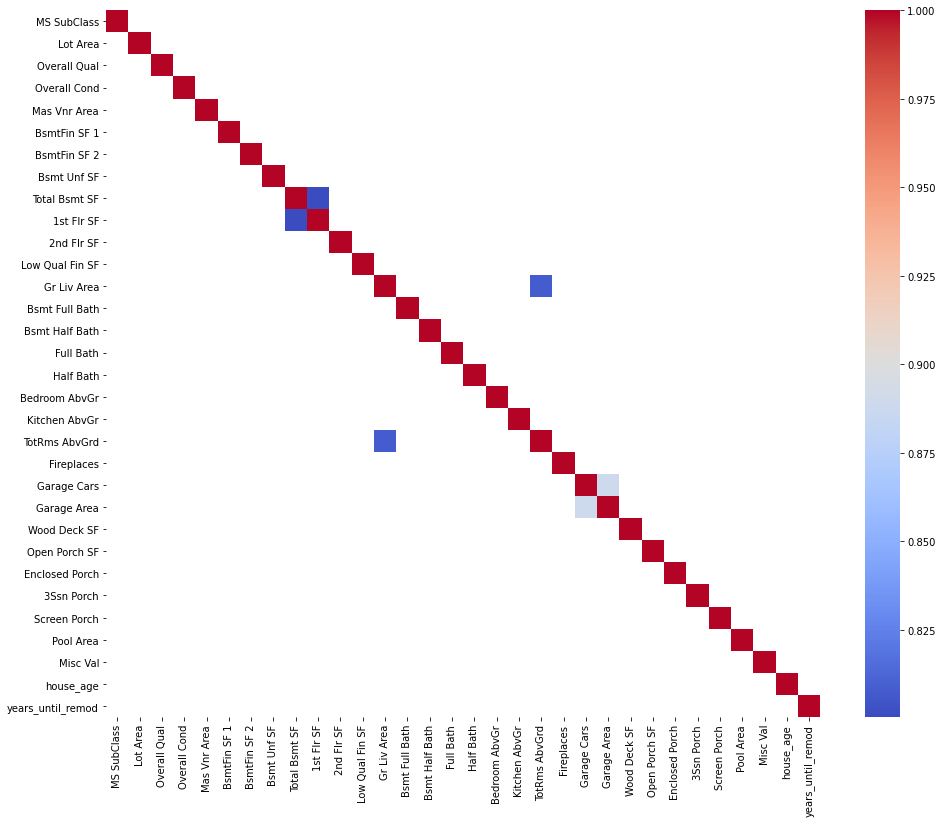

In [15]:
feature_corrs = cleaned_housing_df.drop('SalePrice', axis=1).corr().abs()

fig, ax = plt.subplots(figsize=(16,13))
sns.heatmap(feature_corrs[feature_corrs > 0.7], cmap='coolwarm')

So we've got a few pairs:
* `Total Bsmt SF` and `1st Flr SF`
* `Gr Liv Area` and `TotRms AbvGrd`
* `Garage Cars` and `Garage Area`

We'll keep only three of them. `Garage Area` and `Gr Liv Area` have continious values which is better. And there are a few more specific columns for the basement so we can delete `Total Bsmt SF`.

In [16]:
corr_cols_drop = ['Total Bsmt SF', 'TotRms AbvGrd', 'Garage Cars']

cleaned_housing_df = cleaned_housing_df.drop(corr_cols_drop, axis=1)

### Categorical features

We have a lot of `object` columns in our data set. Some of them could be used in the model.

In [17]:
cleaned_housing_df.select_dtypes('object').head()

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,...,Heating QC,Central Air,Electrical,Kitchen Qual,Functional,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,Fa,Y,SBrkr,TA,Typ,Attchd,Fin,TA,TA,P
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,...,TA,Y,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,TA,Y,SBrkr,Gd,Typ,Attchd,Unf,TA,TA,Y
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,Ex,Y,SBrkr,Ex,Typ,Attchd,Fin,TA,TA,Y
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,Gd,Y,SBrkr,TA,Typ,Attchd,Fin,TA,TA,Y


To use them we should transfrom them to the `category` type first. Also we havw three numeric columns that should be transfrom aswell:
* `MS SubClass`
* `Overall Qual`
* `Overall Cond`

In [18]:
object_cols = cleaned_housing_df.select_dtypes('object').columns.to_list()

num_cols = ['MS SubClass', 'Overall Qual', 'Overall Cond']

cat_cols = object_cols + num_cols
print(cat_cols)

cleaned_housing_df[cat_cols] = cleaned_housing_df[cat_cols].astype('category')

['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'MS SubClass', 'Overall Qual', 'Overall Cond']


Let's try to understand which one would be really helpful.

Let's delete `category` columns that don't have more than **90%** of values belong the same category. There is no variability in the data for the model to capture.

In [19]:
for col in cat_cols:
    top_cat = cleaned_housing_df[col].value_counts()[0]
    full_len = cleaned_housing_df.shape[0]
    
    if top_cat > 0.9*full_len:
        cleaned_housing_df = cleaned_housing_df.drop(col, axis=1)
        print(col)
        
cleaned_housing_df.select_dtypes('category').head()

Street
Utilities
Land Slope
Condition 2
Roof Matl
Bsmt Cond
Heating
Central Air
Electrical
Functional
Garage Qual
Garage Cond
Paved Drive


,MS SubClass,MS Zoning,Lot Shape,Land Contour,Lot Config,Neighborhood,Condition 1,Bldg Type,House Style,Overall Qual,...,Exter Cond,Foundation,Bsmt Qual,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating QC,Kitchen Qual,Garage Type,Garage Finish
0,20,RL,IR1,Lvl,Corner,NAmes,Norm,1Fam,1Story,6,...,TA,CBlock,TA,Gd,BLQ,Unf,Fa,TA,Attchd,Fin
1,20,RH,Reg,Lvl,Inside,NAmes,Feedr,1Fam,1Story,5,...,TA,CBlock,TA,No,Rec,LwQ,TA,TA,Attchd,Unf
2,20,RL,IR1,Lvl,Corner,NAmes,Norm,1Fam,1Story,6,...,TA,CBlock,TA,No,ALQ,Unf,TA,Gd,Attchd,Unf
3,20,RL,Reg,Lvl,Corner,NAmes,Norm,1Fam,1Story,7,...,TA,CBlock,TA,No,ALQ,Unf,Ex,Ex,Attchd,Fin
4,60,RL,IR1,Lvl,Inside,Gilbert,Norm,1Fam,2Story,5,...,TA,PConc,Gd,No,GLQ,Unf,Gd,TA,Attchd,Fin


Now let's delete `category` columns that have more than **15** unique values. It'll greatly reduce amount of dummies columns.

In [20]:
uniq_cat = cleaned_housing_df.select_dtypes('category').nunique()

more_15_cols = uniq_cat[uniq_cat > 15].index
print(more_15_cols)

cleaned_housing_df = cleaned_housing_df.drop(more_15_cols, axis=1)

Index(['MS SubClass', 'Neighborhood', 'Exterior 1st', 'Exterior 2nd'], dtype='object')


And finally we'll create dummies for `category` columns with non numeric values.

In [21]:
all_cat_cols = cleaned_housing_df.select_dtypes('category').columns.to_list()

non_num_cols = [col for col in all_cat_cols if col not in num_cols]

dummies_cols = pd.get_dummies(cleaned_housing_df[non_num_cols])

cleaned_housing_df = cleaned_housing_df.join(dummies_cols)
    
cleaned_housing_df = cleaned_housing_df.drop(non_num_cols, axis=1)
cleaned_housing_df.columns

Index(['Lot Area', 'Overall Qual', 'Overall Cond', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF',
       ...
       'Kitchen Qual_TA', 'Garage Type_2Types', 'Garage Type_Attchd',
       'Garage Type_Basment', 'Garage Type_BuiltIn', 'Garage Type_CarPort',
       'Garage Type_Detchd', 'Garage Finish_Fin', 'Garage Finish_RFn',
       'Garage Finish_Unf'],
      dtype='object', length=137)

### Feature selection

The scikit-learn library provides the `SelectKBest` class that can be used with a suite of different statistical tests to select a specific number of features.

We'll be using the [ANOVA F-value method](https://en.wikipedia.org/wiki/Analysis_of_variance).

In [85]:
np.set_printoptions(precision=2)
np.seterr(divide='ignore')

X_test = cleaned_housing_df.drop('SalePrice', axis=1)
Y_target = cleaned_housing_df['SalePrice']

test = SelectKBest(score_func=f_classif, k=100)
fit = test.fit(X_test, Y_target)

print('Score for each feature:\n', fit.scores_)

features = fit.transform(X_test)

feature_cols = fit.get_support(indices=True)
X_test.iloc[:, feature_cols].head()

Score for each feature:
 [1.67 7.41 1.25 2.74 2.17 0.81 1.51 3.4  1.64 1.01 4.57 1.26 0.77 3.13
 1.5  1.29 0.99 1.86 3.25 1.37 1.42 0.81 0.93 0.95 0.81 1.75 3.1  2.42
  inf 3.11 1.7  2.76 0.59 1.23 1.23 1.41 1.09 1.27 1.5  0.88 1.97 0.79
 1.22 1.02 1.01 1.04 0.96 0.97 0.96 0.93 1.04 1.15 1.6  0.33 1.28 0.77
 0.47 0.97 0.74 1.1  0.91 1.08 0.85 0.8  1.01 1.37 0.9  1.4  0.77 0.67
 0.5  1.35 1.13 1.43 1.14 0.37 0.73 1.33 0.23 1.57 2.03 7.8  1.7  2.98
 3.15 1.28 1.33 0.82 1.66 0.9  1.09 1.49 2.39 1.94 1.42 0.55 4.84 1.31
 2.2  3.68 2.34 1.36 1.9  0.95 1.45 0.79 0.67 1.75 0.83 0.83 1.19 0.85
 0.65 1.01 0.53 0.59 0.74 1.69 1.14 0.88 1.54 1.21 4.98 1.33 2.17 0.61
 2.27 0.57 1.3  0.64 1.95 1.87 1.42 2.07 1.43 2.4 ]


,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,Bsmt Unf SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,...,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_TA,Garage Type_Attchd,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Finish_Fin,Garage Finish_RFn,Garage Finish_Unf
0,31770,6,5,112.0,639.0,441.0,1656,0,0,1656,...,0,0,1,1,0,0,0,1,0,0
1,11622,5,6,0.0,468.0,270.0,896,0,0,896,...,0,0,1,1,0,0,0,0,0,1
2,14267,6,6,108.0,923.0,406.0,1329,0,0,1329,...,0,1,0,1,0,0,0,0,0,1
3,11160,7,5,0.0,1065.0,1045.0,2110,0,0,2110,...,0,0,0,1,0,0,0,1,0,0
4,13830,5,5,0.0,791.0,137.0,928,701,0,1629,...,0,0,1,1,0,0,0,1,0,0


In [54]:
pupa = X_test.iloc[:, feature_cols]

pupa.columns

Index(['Overall Qual', '1st Flr SF', 'Gr Liv Area', 'Garage Area',
       'MS Zoning_A (agr)', 'Exter Qual_Ex', 'Exter Qual_TA', 'Bsmt Qual_Ex',
       'Bsmt Qual_Po', 'Kitchen Qual_Ex'],
      dtype='object')

Now let's update our functions again.

In [23]:
def transform_features(df):
    '''
    First func fill columns with 10% NaNs, drop rest columns NaNs
    and create some new features
    
    Then func creates traing and test data sets
    
    df - whole original data set
    '''
    
    #Fill NaNs with modes in the 10% columns
    missing_values_count = df.isnull().sum()

    cols_to_fill = missing_values_count[(missing_values_count < 0.1*df.shape[0]
                               ) & (missing_values_count != 0)].index

    modes = df[cols_to_fill].mode()
    modes_dict = modes.T[0].to_dict()

    df[cols_to_fill] = df[cols_to_fill].fillna(value=modes_dict)
    
    #Delete rest columns with NaN
    missing_values_count = housing_df.isnull().sum()
    cols_to_drop = missing_values_count[missing_values_count > 0].index

    cleaned_df = df.drop(cols_to_drop, axis=1)
    
    #Create new features
    cleaned_df['house_age'] = cleaned_df[
                        'Yr Sold'] - cleaned_df['Year Built']

    cleaned_df['years_until_remod'] = cleaned_df[
                            'Yr Sold'] - cleaned_df['Year Remod/Add']
      
    #Columns list that uselees for model
    useless_cols = ['Order', 'PID', 'Mo Sold', 'Yr Sold', 'Year Built', 'Year Remod/Add',
                'Garage Yr Blt', 'Sale Type', 'Sale Condition', 'Total Bsmt SF', 'TotRms AbvGrd', 'Garage Cars']

    cleaned_df = cleaned_df.drop(useless_cols, axis=1)
    
    #Transformation to the categortical 
    object_cols = cleaned_df.select_dtypes('object').columns.to_list()
    num_cols = ['MS SubClass', 'Overall Qual', 'Overall Cond']
    cat_cols = object_cols + num_cols

    cleaned_df[cat_cols] = cleaned_df[cat_cols].astype('category')
    
    #Clean categorical
    for col in cat_cols:
        top_cat = cleaned_df[col].value_counts()[0]
        full_len = cleaned_df.shape[0]
    
        if top_cat > 0.9*full_len:
            cleaned_df = cleaned_df.drop(col, axis=1)

    uniq_cat = cleaned_df.select_dtypes('category').nunique()
    more_15_cols = uniq_cat[uniq_cat > 15].index

    cleaned_df = cleaned_df.drop(more_15_cols, axis=1)
    
    #Get dummies
    all_cat_cols = cleaned_df.select_dtypes('category').columns.to_list()
    non_num_cols = [col for col in all_cat_cols if col not in num_cols]

    dummies_cols = pd.get_dummies(cleaned_df[non_num_cols])
    cleaned_df = cleaned_df.join(dummies_cols)
    cleaned_df = cleaned_df.drop(non_num_cols, axis=1)
    
    #Split the data set
    train_len = round(0.75 * cleaned_df.shape[0])
    
    train_set = cleaned_df[:train_len]
    test_set = cleaned_df[train_len:]
    
    return train_set, test_set

In [24]:
def select_features(df):
    '''
    Func returns feature numeric columns from the data set
    excluding columns with missing values
    
    df - whole original data set    
    '''
    features_df = df.select_dtypes(include=['number', 'category'])
    
    return features_df

In [25]:
train_and_test(housing_df)

25337.11555343981

In [37]:
def transform_features_2(df):
    '''
    First func fill columns with 10% NaNs, drop rest columns NaNs
    and create some new features
    
    Then func creates traing and test data sets
    
    df - whole original data set
    '''
    
    #Fill NaNs with modes in the 10% columns
    missing_values_count = df.isnull().sum()

    cols_to_fill = missing_values_count[(missing_values_count < 0.1*df.shape[0]
                               ) & (missing_values_count != 0)].index

    modes = df[cols_to_fill].mode()
    modes_dict = modes.T[0].to_dict()

    df[cols_to_fill] = df[cols_to_fill].fillna(value=modes_dict)
    
    #Delete rest columns with NaN
    missing_values_count = housing_df.isnull().sum()
    cols_to_drop = missing_values_count[missing_values_count > 0].index

    cleaned_df = df.drop(cols_to_drop, axis=1)
    
    #Create new features
    cleaned_df['house_age'] = cleaned_df[
                        'Yr Sold'] - cleaned_df['Year Built']

    cleaned_df['years_until_remod'] = cleaned_df[
                            'Yr Sold'] - cleaned_df['Year Remod/Add']
      
    #Columns list that uselees for model
    useless_cols = ['Order', 'PID', 'Mo Sold', 'Yr Sold', 'Year Built', 'Year Remod/Add',
                'Garage Yr Blt', 'Sale Type', 'Sale Condition', 'Total Bsmt SF', 'TotRms AbvGrd', 'Garage Cars']

    cleaned_df = cleaned_df.drop(useless_cols, axis=1)
    
    #Transformation to the categortical 
    cat_cols = ['MS SubClass', 'Overall Qual', 'Overall Cond']

    cleaned_df[cat_cols] = cleaned_df[cat_cols].astype('category')
    
    #Clean categorical
    for col in cat_cols:
        top_cat = cleaned_df[col].value_counts()[0]
        full_len = cleaned_df.shape[0]
    
        if top_cat > 0.9*full_len:
            cleaned_df = cleaned_df.drop(col, axis=1)

    uniq_cat = cleaned_df.select_dtypes('category').nunique()
    more_15_cols = uniq_cat[uniq_cat > 15].index

    cleaned_df = cleaned_df.drop(more_15_cols, axis=1)
    
    obj_cols = cleaned_df.select_dtypes('object').columns
    cleaned_df = cleaned_df.drop(obj_cols, axis=1)
       
    #Split the data set
    train_len = round(0.75 * cleaned_df.shape[0])
    
    train_set = cleaned_df[:train_len]
    test_set = cleaned_df[train_len:]
    
    return train_set, test_set

In [69]:
def select_features_2(df, k):
    '''
    Func returns feature numeric columns from the data set
    excluding columns with missing values
    
    Return feature columns
    
    df - whole original data set 
    k - number of features to use in the model
    '''
    np.set_printoptions(precision=2)
    np.seterr(divide='ignore')

    X_test = df.drop('SalePrice', axis=1)
    Y_target = df['SalePrice']

    test = SelectKBest(score_func=f_classif, k=k)
    fit = test.fit(X_test, Y_target)

    feature_cols = fit.get_support(indices=True)
    features_df = X_test.iloc[:, feature_cols]

    return features_df

In [80]:
def train_and_test_2(df, k):
    '''
    Func train and test linear regression model on df.
    Returns RMSE
    
    df - whole original data set    
    '''
    train_set, test_set = transform_features(df)

    #Take all numeric columns except target from df returned from select_features()
    training = select_features_2(train_set, k).columns
    target = 'SalePrice'
    
    lin_reg = LinearRegression().fit(train_set[training],
                                      train_set[target])
    
    predictions = lin_reg.predict(test_set[training])
    
    rmse = mean_squared_error(test_set[target], predictions, squared=False)
    
    return rmse

In [83]:
train_and_test_2(housing_df, 128)

Index(['Lot Area', 'Overall Qual', 'Overall Cond', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF',
       ...
       'Kitchen Qual_Gd', 'Kitchen Qual_TA', 'Garage Type_2Types',
       'Garage Type_Attchd', 'Garage Type_BuiltIn', 'Garage Type_CarPort',
       'Garage Type_Detchd', 'Garage Finish_Fin', 'Garage Finish_RFn',
       'Garage Finish_Unf'],
      dtype='object', length=128)


C:\Users\3axap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 28  78  99 120] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\3axap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


25335.190247652656

In [88]:
xyz, zux = transform_features(housing_df)
xyz

,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,...,Kitchen Qual_TA,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Finish_Fin,Garage Finish_RFn,Garage Finish_Unf
0,31770,6,5,112.0,639.0,0.0,441.0,1656,0,0,...,1,0,1,0,0,0,0,1,0,0
1,11622,5,6,0.0,468.0,144.0,270.0,896,0,0,...,1,0,1,0,0,0,0,0,0,1
2,14267,6,6,108.0,923.0,0.0,406.0,1329,0,0,...,0,0,1,0,0,0,0,0,0,1
3,11160,7,5,0.0,1065.0,0.0,1045.0,2110,0,0,...,0,0,1,0,0,0,0,1,0,0
4,13830,5,5,0.0,791.0,0.0,137.0,928,701,0,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193,8190,4,6,0.0,732.0,0.0,216.0,948,0,0,...,1,0,0,0,0,0,1,0,0,1
2194,10896,6,7,0.0,256.0,0.0,1184.0,1440,1440,515,...,0,0,1,0,0,0,0,0,0,1
2195,10890,5,6,0.0,371.0,0.0,925.0,1296,1296,0,...,1,0,1,0,0,0,0,0,0,1
2196,10592,6,7,0.0,0.0,0.0,602.0,900,602,0,...,0,0,0,0,0,0,1,0,0,1


In [90]:
ffff = select_features_2(xyz, 100)
ffff

C:\Users\3axap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 28  78  99 120] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\3axap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,Bsmt Unf SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,...,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_TA,Garage Type_Attchd,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Finish_Fin,Garage Finish_RFn,Garage Finish_Unf
0,31770,6,5,112.0,639.0,441.0,1656,0,0,1656,...,0,0,1,1,0,0,0,1,0,0
1,11622,5,6,0.0,468.0,270.0,896,0,0,896,...,0,0,1,1,0,0,0,0,0,1
2,14267,6,6,108.0,923.0,406.0,1329,0,0,1329,...,0,1,0,1,0,0,0,0,0,1
3,11160,7,5,0.0,1065.0,1045.0,2110,0,0,2110,...,0,0,0,1,0,0,0,1,0,0
4,13830,5,5,0.0,791.0,137.0,928,701,0,1629,...,0,0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193,8190,4,6,0.0,732.0,216.0,948,0,0,948,...,0,0,1,0,0,0,1,0,0,1
2194,10896,6,7,0.0,256.0,1184.0,1440,1440,515,3395,...,1,0,0,1,0,0,0,0,0,1
2195,10890,5,6,0.0,371.0,925.0,1296,1296,0,2592,...,0,0,1,1,0,0,0,0,0,1
2196,10592,6,7,0.0,0.0,602.0,900,602,0,1502,...,0,1,0,0,0,0,1,0,0,1


In [92]:
xyz.iloc[:, [28, 78, 99, 120]]

,years_until_remod,Mas Vnr Type_BrkFace,Bsmt Qual_Gd,Heating QC_Gd
0,50,0,0,0
1,49,0,0,0
2,52,1,0,0
3,42,0,0,0
4,12,0,1,1
...,...,...,...,...
2193,53,0,0,0
2194,12,0,0,0
2195,57,0,0,0
2196,11,0,0,0
